In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import os

In [2]:
#read the data
covid_path = r'C:\Users\lizhu\Desktop\ece143\projec\covid19-dashboard\temp_data' 
vac_data_path_base = r'C:\Users\lizhu\Desktop\ece143\projec\covid19-dashboard\data\COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv'
vac_data = pd.read_csv(vac_data_path_base)
#print(vac_data.head())
df = pd.read_csv(covid_path+'/01-01-2021.csv')
print(df.head())
#temp_data\01-01-2021.csv

   Unnamed: 0  Province_State Country_Region          Last_Update      Lat  \
0           0         Alabama             US  2021-01-02 05:30:44  32.3182   
1           1          Alaska             US  2021-01-02 05:30:44  61.3707   
2           2  American Samoa             US  2021-01-02 05:30:44 -14.2710   
3           3         Arizona             US  2021-01-02 05:30:44  33.7298   
4           4        Arkansas             US  2021-01-02 05:30:44  34.9697   

      Long_  Confirmed  Deaths  Recovered    Active  FIPS  Incident_Rate  \
0  -86.9023     365747    4872   202137.0  158738.0   1.0    7459.375895   
1 -152.4044      47019     206     7165.0   39648.0   2.0    6427.355802   
2 -170.1320          0       0        NaN       NaN  60.0       0.000000   
3 -111.4312     530267    9015    76934.0  444318.0   4.0    7285.171274   
4  -92.3731     229442    3711   199247.0   26484.0   5.0    7602.945718   

   Total_Test_Results  People_Hospitalized  Case_Fatality_Ratio         UI

In [3]:
class data_reader:
    '''
    My own version of reading the data
    folder: the path to the folder of the CSSE US data
    path = 'COVID-19_Vaccinations_in_the_United_States_County.csv'

    This one is not used in the final project
    '''
    def __init__(self,folder) -> None:
        assert isinstance(folder, str)
        print('Initializing folder: ', folder)
        self.folder = folder
        first_f = os.listdir(folder)[0]
        data = pd.read_csv(os.path.join(folder,first_f), index_col=1)
        self.states = set(data.index)
        self.timeline = []
        for i in os.listdir(folder)[:-1]:
            self.timeline.append(pd.Timestamp(i[:-4]))
        print('Finished initialization')
        

    def read_trend(self,state):
        '''
        read the data of a given state
        '''  
        #assert (state in self.states) and isinstance(state, str) 
        infect = []
        death = []
        recovered = []
        incident = []
        for filename in os.listdir(self.folder)[:-1]:  
            data = pd.read_csv(os.path.join(self.folder,filename), index_col=1) 
            infect.append(data.loc[state,'Confirmed'])
            death.append(data.loc[state,'Deaths'])
            recovered.append(data.loc[state,'Recovered'])
            incident.append(data.loc[state,'Incident_Rate'])
        
        stat = pd.DataFrame({'infect':infect, 'death':death, 'recovered':recovered, 'incident_rate':incident}, index=self.timeline)
        stat = stat.sort_index()
        #print(stat.head())
        #print(stat.tail())
        return stat

In [4]:
#read data
covid_path = r'C:\Users\lizhu\Desktop\ece143\projec\covid19-dashboard\temp_data'
rd = data_reader(covid_path)
#first_f = os.listdir(covid_path)[0]
#data = pd.read_csv(os.path.join(covid_path,first_f), index_col=1)
covid_data = rd.read_trend('California')
print(covid_data.head())
#print(data.head())

Initializing folder:  C:\Users\lizhu\Desktop\ece143\projec\covid19-dashboard\temp_data
Finished initialization
             infect  death  recovered  incident_rate
2020-11-15  1048647  18306        NaN    2654.209053
2020-11-16  1058764  18326        NaN    2679.851751
2020-11-17  1070042  18379        NaN    2708.450496
2020-11-18  1082467  18492        NaN    2739.929363
2020-11-19  1096728  18581        NaN    2776.044770


C:\Users\lizhu\AppData\Local\Temp\ipykernel_21892\3763552119.py:12: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(death_per_day+1),label = 'death')


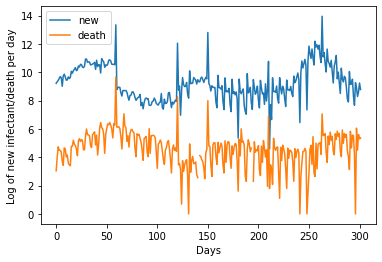

In [5]:
inci = np.array(covid_data['incident_rate'])
infect =  np.array(covid_data['infect'])
deaths = np.array(covid_data['death'])


new_per_day = infect[1:]-infect[:-1]
death_per_day = deaths[1:]-deaths[:-1]

# plot
#plus 1 to avoid 0 in log
plt.plot(np.log(new_per_day+1), label='new')
plt.plot(np.log(death_per_day+1),label = 'death')
plt.xlabel('Days')
plt.ylabel('Log of new infectant/death per day')
plt.legend()
plt.show()

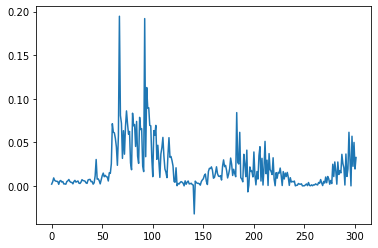

In [6]:
death_rate = death_per_day/new_per_day
plt.plot(death_rate, label = 'death_rate')

Can see that the death rate is smaller during the second and third peak.

# Conclusion 1:
There are roughly 2 waves of pandemic. (Covid-19, Omicron)
The first wave has lower infectivity (less new infectants per day), but higher fatality
The second wave has higher infectivity, but lower fatality

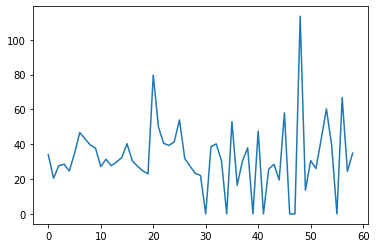

In [7]:
# 载入数据
#the data in California have some outliers and is not good for learning
covid_data = rd.read_trend('Washington') 
r1start = pd.to_datetime('2020-10-15')
r1end = pd.to_datetime('2021-02-15')
round1_data = covid_data.loc[np.logical_and(covid_data.index>=r1start, covid_data.index<=r1end),:]


inci = np.array(round1_data['incident_rate'])
new_per_day = inci[1:]-inci[:-1]
plt.plot(new_per_day)
plt.show()

In [8]:
R0 = 2
#initial values of the model
S =  100000-(1+R0)*inci[0]
E = R0*inci[0]
I = inci[0]
R = 0

In [9]:
def loss(orig,pred):
    return sum(np.square(orig-pred))

In [10]:
def base_seir_model(s=100000,e=0,i=1000,r=0, beta=0.1066, sigma=0.18, gamma=0.0714, t=100):
    '''
    A basic suspect, exposed, infected, recovered model,
    which models the trend of the population in each part

    input:
    s,e,i,r: the initial population of each part
    beta: The rate of transmission. 
    sigma: The rate of exposed people became infectants (rate of symptom reveals)
    gamma: rate of recovery
    t: the total time length to do the prediction

    Output:
    A pandas array P
    P[0]: the Suspectable population trend
    P[1]: the Exposed population trend
    P[2]: the Infectant population trend
    P[3]: the Recovered population trend
    P[4]: New infectant per day
    '''
    assert s>0 and e>=0 and i>0 and r>=0, 'Invalid input for population!'
    assert beta>0 and sigma>0 and gamma>0,'Invalid input for parameters!'
    assert isinstance(t,int) and t>0,'Invalid input for time!'

    S, E, I, R = [s], [e], [i], [r]
    new_infect = [0]
    dt=1
    for _ in range(t-1):
        new = sigma*E[-1]
        new_infect.append(new)
        N=S[-1]+E[-1]+I[-1]+R[-1]
        next_S = S[-1] - (beta*S[-1]*I[-1])/N*dt
        next_E = E[-1] + (beta*S[-1]*I[-1]/N - new)*dt
        next_I = I[-1] + (new - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    
    data = np.stack([S, E, I, R,new_infect]).T
    s = pd.DataFrame(data, columns=['Susceptible','Exposed','Infectant','Recovered','New Infect'])
    return s

In [73]:
min_loss = 10000000
b=0
s=0
g=0
#compute the parameters that best fit the rwal data
for beta in np.arange(0.01,1,0.01):
    for sigma in np.arange(0.01,1.,0.01):
        for gamma in np.arange(0.01,1.,0.01):
            result = base_seir_model(S,E,I,R,beta,sigma,gamma, t = len(inci))
            new_pre = result['New Infect'][1:]
            c_loss = loss(new_per_day,new_pre)
            if c_loss <min_loss:
                min_loss=c_loss
                b=beta
                s=sigma
                g=gamma

print(b,s,g)

10000 0.02 0.03 0.01
20000 0.03 0.05 0.02
30000 0.04 0.06999999999999999 0.03
40000 0.05 0.09 0.04
50000 0.060000000000000005 0.11 0.05
60000 0.06999999999999999 0.13 0.060000000000000005
70000 0.08 0.15000000000000002 0.06999999999999999
80000 0.09 0.17 0.08
90000 0.09999999999999999 0.19 0.09
100000 0.11 0.21000000000000002 0.09999999999999999
110000 0.12 0.23 0.11
120000 0.13 0.25 0.12
130000 0.14 0.27 0.13
140000 0.15000000000000002 0.29000000000000004 0.14
150000 0.16 0.31 0.15000000000000002
160000 0.17 0.33 0.16
170000 0.18000000000000002 0.35000000000000003 0.17
180000 0.19 0.37 0.18000000000000002
190000 0.2 0.39 0.19
200000 0.21000000000000002 0.41000000000000003 0.2
210000 0.22 0.43 0.21000000000000002
220000 0.23 0.45 0.22
230000 0.24000000000000002 0.47000000000000003 0.23
240000 0.25 0.49 0.24000000000000002
250000 0.26 0.51 0.25
260000 0.27 0.53 0.26
270000 0.28 0.55 0.27
280000 0.29000000000000004 0.5700000000000001 0.28
290000 0.3 0.59 0.29000000000000004
300000 0.31 0

So the parameters given by the model is 0.06, 0.01, 0.01
Beta = 0.06: Roughly speaking, when a patient contact with a susceptible man, there is 6% possibility that the susceptible man become infected.

In [19]:
import plotly.graph_objs as go    
import plotly.offline as py 
#the prediction of the epidemic in a year
result = base_seir_model(S,E,I,R,beta=0.06,sigma=0.01,gamma=0.01, t = 360)
result['Day'] = list(range(360))

trace0 = go.Scatter(
      x = list(range(360)),
      y = result['Susceptible'],
      mode = 'lines',
      name = 'Susceptible'   
)
trace1 = go.Scatter(
      x = list(range(360)),
      y = result['Exposed'],
      mode = 'lines',
      name = 'Exposed'   
)
trace2 = go.Scatter(
      x = list(range(360)),
      y = result['Infectant'],
      mode = 'lines',
      name = 'Exposed'   
)

trace3 = go.Scatter(
      x = list(range(360)),
      y = result['Recovered'],
      mode = 'lines',
      name = 'Exposed'   
)
data = [trace0, trace1,trace2,trace3]
layout = dict(title = 'Epidemic Trend in Washington (Wave 1)', xaxis = dict(title = 'Day'), yaxis = dict(title = 'Population per 100k'),title_x=0.5)
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='SEIR wave 1')


We can see that the sigma(rate of symptom reveals) gamma(rate of recovery) is much lower than common sense (usually around 0.07). This is because at that time our hospital cannot handle so many patients, which leads to a low recovery rate, and this further influences the rate of symptom reveals

In [13]:
#test if the prediction 
new_in = result['New Infect'][1:len(inci)+1]
trace0 = go.Scatter(
      x = list(range(len(new_in))),
      y = new_in,
      mode = 'lines',
      name = 'Prediction'   
)
trace1 = go.Scatter(
      x = list(range(len(new_in))),
      y = new_per_day,
      mode = 'lines',
      name = 'Real'   
)
data = [trace0, trace1]
layout = dict(title = r'New Infectant (Predict vs. Real)', xaxis = dict(title = 'Day'), yaxis = dict(title = 'Population per 100k'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='New Infectant (Predict vs. Real)')


In [25]:
covid_data = rd.read_trend('Washington')
r2start = pd.to_datetime('2021-12-30')
round2_data = covid_data.loc[covid_data.index>=r2start,:]
round2_data = covid_data.loc[covid_data.index>=r2start,:]
inci = np.array(round2_data['incident_rate'])
new_per_day = inci[1:]-inci[:-1]
plt.plot(new_per_day)
plt.show()
#print(inci)

ValueError: Length of values (318) does not match length of index (303)

don't know why the result do not works, but the parameters are computed already.

In [36]:
R0 = 2
#initial values of the model
S =  100000-inci[0]
E = R0*inci[0]
I = inci[0]
R = 0

In [24]:
min_loss = 10000000
b=0
s=0
g=0
for beta in np.arange(0.01,1,0.01):
    for sigma in np.arange(0.01,1.,0.01):
        for gamma in np.arange(0.01,1.,0.01):
            result = base_seir_model(S,E,I,R,beta,sigma,gamma, t = len(inci))
            new_pre = result['New Infect'][1:]
            c_loss = loss(new_per_day,new_pre)
            if c_loss <min_loss:
                min_loss=c_loss
                b=beta
                s=sigma
                g=gamma

print(b,s,g)

KeyboardInterrupt: 

In [18]:
#the prediction of the epidemic in a year
import plotly.graph_objs as go    
import plotly.offline as py 
#the prediction of the epidemic in a year
result = base_seir_model(S,E,I,R,beta=0.14,sigma=0.05,gamma=0.32, t = 360)
result['Day'] = list(range(360))

trace0 = go.Scatter(
      x = list(range(360)),
      y = result['Susceptible'],
      mode = 'lines',
      name = 'Susceptible'   
)
trace1 = go.Scatter(
      x = list(range(360)),
      y = result['Exposed'],
      mode = 'lines',
      name = 'Exposed'   
)
trace2 = go.Scatter(
      x = list(range(360)),
      y = result['Infectant'],
      mode = 'lines',
      name = 'Exposed'   
)

trace3 = go.Scatter(
      x = list(range(360)),
      y = result['Recovered'],
      mode = 'lines',
      name = 'Exposed'   
)
data = [trace0, trace1,trace2,trace3]
layout = dict(title = 'Epidemic Trend in Washington (Wave 2)', xaxis = dict(title = 'Day'), yaxis = dict(title = 'Population per 100k'), title_x=0.5)
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='SEIR wave 1')


Even though Omicron has a larger beta(possibility of transmission), but also a higher recovery rate. It infects a lot of people, but it’s not scary.
The pandemic soon stops.

In [20]:
#test if the prediction 
new_in = result['New Infect'][1:len(inci)+1]
trace0 = go.Scatter(
      x = list(range(len(new_in))),
      y = new_in,
      mode = 'lines',
      name = 'Prediction'   
)
trace1 = go.Scatter(
      x = list(range(len(new_in))),
      y = new_per_day,
      mode = 'lines',
      name = 'Real'   
)
data = [trace0, trace1]
layout = dict(title = r'New Infectant (Predict vs. Real)', xaxis = dict(title = 'Day'), yaxis = dict(title = 'Population per 100k'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='New Infectant (Predict vs. Real)')

SEIR model is helpful when computing the internal relations. 
However, it considers too many features and is very likely to be influenced by other features. 
The prediction is not very accurate.

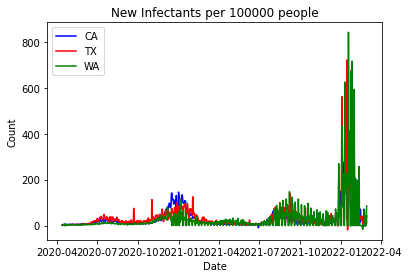

In [5]:
#new infectants per day
inci_ca = np.array(idr_ca['incident_rate'])
new_per_day_ca = inci_ca[1:]-inci_ca[:-1]
inci_tx = np.array(idr_tx['incident_rate'])
new_per_day_tx = inci_tx[1:]-inci_tx[:-1]
inci_wa = np.array(idr_wa['incident_rate'])
new_per_day_wa = inci_wa[1:]-inci_wa[:-1]
date = idr_ca.index[1:]
plt.plot(date, new_per_day_ca, color = 'blue', label = 'CA')
plt.plot(date, new_per_day_tx, color = 'red', label = 'TX')
plt.plot(date, new_per_day_wa, color = 'green', label = 'WA')
plt.legend()
plt.title('New Infectants per 100000 people')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

The plot shows that there are roughly 3 waves of the pandemic

In [76]:
b = data[data['Location']=='CA']
b.fillna(0)
b.index=list(pd.to_datetime(b['Date']))
print(b.head())
#new_per_day= np.array(b['Distributed'])[1:] - np.array(b['Distributed'])[:-1]
#plt.plot(list(b['Date'][:-1]),new_per_day)

                  Date  MMWR_week Location  Distributed  Distributed_Janssen  \
2022-02-27  02/27/2022          9       CA     85834025              3685200   
2022-02-26  02/26/2022          8       CA     85834025              3685200   
2022-02-25  02/25/2022          8       CA     85777025              3683900   
2022-02-24  02/24/2022          8       CA     85679525              3683900   
2022-02-23  02/23/2022          8       CA     85646925              3683600   

            Distributed_Moderna  Distributed_Pfizer  Distributed_Unk_Manuf  \
2022-02-27             30682620            51466205                      0   
2022-02-26             30682620            51466205                      0   
2022-02-25             30655520            51437605                      0   
2022-02-24             30644420            51351205                      0   
2022-02-23             30612220            51351105                      0   

            Dist_Per_100K  Distributed_Per_100k_12

In [53]:
inci = np.array(round1_data['incident_rate'])
new_per_day = inci[1:]-inci[:-1]


S =  100000-inci[0]
# 设置模型初始值
E = 0
I = inci[0]
R = 0
init_vals = [S, E, I, R]  

l = make_loss(init_vals, new_per_day)

# 设置BO参数
pbounds = {'sigma': (0.1, 1), 'beta': (0, 1), 'gamma': (0, 1)}
optimizer = BayesianOptimization(
    f=l,
    pbounds=pbounds,
    verbose=1,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(
    init_points=2,
    n_iter=100,
)

# 开始BO
print(optimizer.max)
r = optimizer.max['params']

|   iter    |  target   |   beta    |   gamma   |   sigma   |
-------------------------------------------------------------
|  11       | -4.507e+0 |  0.0      |  1.0      |  1.0      |
|  35       | -4.493e+0 |  0.006696 |  0.138    |  0.7571   |
|  49       | -4.475e+0 |  0.2199   |  1.0      |  0.1      |
|  51       | -1.435e+0 |  0.01366  |  0.005685 |  0.3199   |
{'target': -1435.1245801839516, 'params': {'beta': 0.013661239945000903, 'gamma': 0.0056853352667423085, 'sigma': 0.31989170217970553}}


In [77]:
from datetime import datetime, timedelta
date = '2022-02-27'
datetime_object = datetime.strptime(date, '%Y-%m-%d')
past_days = 400
next_days = 0
start_date = datetime_object + timedelta(days=-past_days)
end_date = datetime_object + timedelta(days=next_days)

date_range= pd.date_range(start=start_date, end=end_date, closed='right').strftime('%Y-%m-%d')
print(date_range[0])

2021-01-24


In [ ]:
path = 'C:\Users\lizhu\Desktop\ece143\projec\covid19-dashboard\data\COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv'


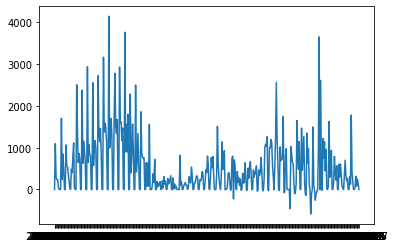

In [82]:
distributed = []
for i in date_range:
    distributed.append(b.loc[i,'Dist_Per_100K'][0])

new = np.array(distributed[1:])-np.array(distributed[:-1])
plt.plot(date_range[1:], new)
plt.show()

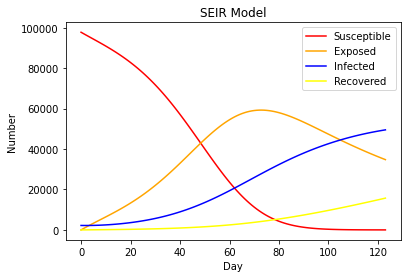

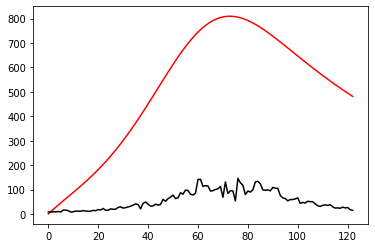

In [54]:
# 用最优参数进行simulation
new_case_per_day = base_seir_model(init_vals[0],init_vals[1],init_vals[2],init_vals[3],
    r['sigma'], r['beta'], r['gamma'], t=np.shape(new_per_day)[0],dt=1, plot=True)
n = np.shape(new_per_day)[0]
t_s = list(range(n))
plt.plot(t_s, new_case_per_day[1:,-1], 'r')
plt.plot(t_s, new_per_day, 'k')
plt.show()

In [45]:
#use round 2 data to do prediction
inci = np.array(round2_data['incident_rate'])
new_per_day = inci[1:]-inci[:-1]

S =  100000-inci[0]
# 设置模型初始值
E = 0
I = inci[0]
R = 0
init_vals = [S, E, I, R]  

print(new_per_day)

|   iter    |  target   |   beta    |   gamma   |   sigma   |
-------------------------------------------------------------
|  3        | -1.991e+0 |  0.4358   |  0.7175   |  0.01417  |
|  46       | -1.954e+0 |  0.4463   |  0.6897   |  0.01385  |
|  59       | -1.808e+0 |  0.9872   |  0.2507   |  0.00376  |
|  90       | -1.756e+0 |  0.008966 |  0.00544  |  0.5066   |
{'target': -17562.65663435294, 'params': {'beta': 0.00896631561408201, 'gamma': 0.0054395418387247485, 'sigma': 0.5065591130720906}}


In [87]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=6, include_bias=False)
poly_features = poly.fit_transform(np.array(range(399)).reshape(-1, 1))
#predict_features = poly.fit_transform(np.array(range(100,200)).reshape(-1, 1))

In [4]:
# 用最优参数进行simulation
S =  100000-1000
# 设置模型初始值
E = 0
I = 1000
R = 0
init_vals = [S, E, I, R]  
new_case_per_day = base_seir_model(init_vals[0],init_vals[1],init_vals[2],init_vals[3],
    0.3, 0.07, 0.05, t=np.shape(new_per_day)[0],dt=1, plot=True)
n = np.shape(new_per_day)[0]
t_s = list(range(n))
plt.plot(t_s, new_case_per_day[1:,-1], 'r')
plt.plot(t_s, new_per_day, 'k')
plt.show()

NameError: name 'new_per_day' is not defined

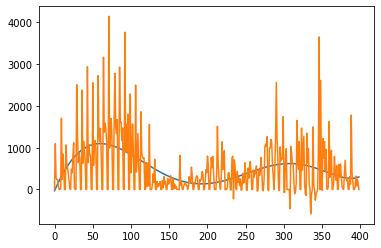

In [88]:
from sklearn.linear_model import LinearRegression
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, new)
y_predicted = poly_reg_model.predict(poly_features)
trace0 = go.Scatter(
      x = list(range(360)),
      y = result['Susceptible'],
      mode = 'lines',
      name = 'Susceptible'   
)
trace1 = go.Scatter(
      x = list(range(360)),
      y = result['Exposed'],
      mode = 'lines',
      name = 'Exposed'   
)
data = [trace0, trace1,trace2,trace3]
layout = dict(title = 'Epidemic Trend in Washington (Wave 2)', xaxis = dict(title = 'Day'), yaxis = dict(title = 'Population per 100k'), title_x=0.5)
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='SEIR wave 1')